# Sweep Delta omega

In [16]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import sin
from numpy import pi
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20

In [2]:
L=1
JM=1.5
Jm=1
ω=2
N=40
U=0.05*JM

En estos subalgoritmos definimos los operadores creación y destrucción de bosones:
$$a |n\rangle = \sqrt{n} |n-1\rangle \qquad a^\dagger |n \rangle = \sqrt{n+1} |n+1  \rangle$$

In [3]:
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))

@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [4]:
#Definimos el producto entre un bra y un ket, si son iguales vale 1 y si son distintos 0
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [5]:
#Este subalgoritmo calcula un elemento de matriz con un Hamiltoniano 
@numba.jit(float64(float64[:],float64[:],float64[:,:], int64, int64, int64, float64, float64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, ω_matrix, N, i, j, J1, J2):
    #<bra|H|ket>
    #Inicialización
    n_eigval=N*(N+1)/2
    H=0
    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))
    #Términos en N y en N(N-1) del Hamiltoniano
    bracket1 = bracket(bra, ket)
    H += np.sum(ω_matrix[i, j]*ket*bracket1)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    #Calculamos los extremos de la cadena
    if (N-1)%2==0:
        J=-J1
    else:
        J=-J2
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    for i in range(len(ket)-1):
            #Recorremos el resto de sitios de la cadena
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            if i%2==0:
                J=-J1
            else:
                J=-J2
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
            H+=term2+term3
    return H

In [6]:
@numba.jit(float64[:,:](float64[:, :],float64[:,:], int64, float64, float64), nopython = True, parallel = False)
def ComputeH(ω_matrix,base, N, J1, J2):
    n_eigval=int(N*(N+1)/2)
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], ω_matrix, N, i2, j2, J1, J2)
    return H

In [7]:
@numba.jit(float64[:, :](int64, float64, float64, float64[:, :]), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2, ω_matrix):
    #Manera rapida de calcular el Hamiltoniano de 1 particula
    H=np.zeros((N,N))
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    H=J1*aux1+J2*aux2+ω_matrix
    return H

In [8]:
@numba.jit(numba.types.Tuple((float64, int64))(float64[:,:]), nopython = True, parallel = False)
def ComputeEigvalMinMaxTop(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    #eigval, eigvect = np.linalg.eig(H)
    eigval, eigvect = eig(H.astype(complex128))
    eigval=eigval.real
    idx = np.argsort(eigval)
    eigval =eigval[idx]
    eigvect = eigvect[:,idx]
    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    #Order=np.argsort(participation_ratio[int(N*(N+1)/2-20):int(N*(N+1)/2)])
    minPR=np.min(participation_ratio)
    indexmin=np.argmin(participation_ratio)
    EigV_i=eigvect[:, indexmin]
    eigvect2D=np.zeros((N, N))
    counter=0
    for i in range(N):
        for j in range(i, N):
            eigvect2D[i, j]=0
            eigvect2D[j, i]=np.abs(EigV_i[counter])**2
            counter+=1
    result= np.where(eigvect2D == np.amax(eigvect2D))
    auxP=list(zip(result[0], result[1]))
    #print(auxP)
    #typev=0 Scatt Edge, type=1 Edge Doublon, type=2 QuasiEdge DOublon
    typev=-1
    if auxP[0][0]==0 and auxP[0][1]==0:
        typev=1
    elif auxP[0][0]==N-1 and auxP[0][1]==N-1:
        typev=1
    elif auxP[0][0]==N-1 and auxP[0][1]==0:
        typev=0
    else:
        typev=2
    return (minPR, typev)
@numba.jit(float64(float64[:,:]), nopython = True, parallel = False)
def ComputeEigvalMinMaxTriv(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    #eigval, eigvect = np.linalg.eig(H)
    eigval, eigvect = eig(H.astype(complex128))
    eigval=eigval.real
    idx = np.argsort(eigval)
    eigval =eigval[idx]
    eigvect = eigvect[:,idx]
    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    #Order=np.argsort(participation_ratio[int(N*(N+1)/2-20):int(N*(N+1)/2)])
    minPR=np.min(participation_ratio)
    return minPR


@numba.jit(float64[:,:,:,:](float64,float64,int64,float64[:,:], int64, int64, float64, float64), nopython = True, parallel = True)
def sweepWSubalg(W_min, W_max, W_points, base, N, n_av, J1, J2):
    n_eigval=int(N*(N+1)/2)
    MinPRvsUHyperMatrix = np.zeros((n_eigval,n_eigval,W_points, n_av))
    MinPRvsU = np.empty(W_points)
    W_array=np.linspace(W_min,W_max,W_points)
    for i in numba.prange(W_points):
        for j in numba.prange(n_av):
            ω_array=ω*(1+W_array[i]*(np.random.rand(N)-0.5))
            ω_matrix=np.zeros((n_eigval, n_eigval))
            counter=0
            for l in range(N):
                for k in range(l,N):
                    ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
                    counter+=1
            MinPRvsUHyperMatrix[:,:,i, j] = ComputeH(ω_matrix,base, N, J1, J2)
    return MinPRvsUHyperMatrix
@numba.jit(float64[:,:,:,:](float64,float64,int64, int64, int64, float64, float64), nopython = True, parallel = True)
def sweepWSubalg1p(W_min, W_max, W_points, N, n_av, J1, J2):
    n_eigval=N
    MinPRvsUHyperMatrix = np.zeros((n_eigval,n_eigval,W_points, n_av))
    MinPRvsU = np.empty(W_points)
    ω_array=np.zeros(N)
    ω_matrix=np.zeros((n_eigval, n_eigval))
    W_array=np.linspace(W_min,W_max,W_points)
    for i in numba.prange(W_points):
        for j in numba.prange(n_av):
            ω_array=ω*(1+W_array[i]*(np.random.rand(N)-0.5))
            ω_matrix=np.zeros((n_eigval, n_eigval))
            for l in range(N):
                ω_matrix[l, l]=ω_array[l]
            #print(ω_matrix)
            MinPRvsUHyperMatrix[:,:,i, j] =FastHamiltonian(N, J1, J2, ω_matrix)
    return MinPRvsUHyperMatrix
    

In [9]:
def ComputeLocalizationLength(eigvect, base):
    eigvecRealSpace=[]
    eigvecRealSpace=np.matmul(base.transpose(), eigvect)
    eigvecRealSpace=np.asarray(eigvecRealSpace)
    aux_eig=(abs(eigvecRealSpace))**2
    eigA= aux_eig[::2]
    eigB=aux_eig[1::2]
    minA=np.argmin(eigA)
    minB=np.argmin(eigB)
    maxA=np.argmax(eigA)
    maxB=np.argmax(eigB)
    xA=np.arange(1, L*len(eigvecRealSpace)+1, 2 )
    xB=np.arange(2, L*len(eigvecRealSpace)+1, 2)
    if maxA>minA:
        eigAuxA=eigA[minA:maxA+1]
        xAuxA=xA[minA:maxA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    else:
        eigAuxA=eigA[maxA:minA+1]
        xAuxA=xA[maxA:minA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    if maxB>minB:
        eigAuxB=eigB[minB:maxB+1]
        xAuxB=xB[minB:maxB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    else:
        eigAuxB=eigB[maxB:minB+1]
        xAuxB=xB[maxB:minB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    return (1/mA, errA/mA**2, 1/mB, errB/mB**2)

In [10]:
n_eigval=int(N*(N+1)/2)
W_min=0
W_max=1
n_points=20
W_array=np.linspace(W_min, W_max, n_points)
n_average=20
Identity=np.identity(N)
base=np.empty((n_eigval, N))
counter=0
for l in range(N):
    for k in range(l,N):
        ketB=Identity[k,:]+Identity[l,:]
        #print(ketB)
        base[counter, :]=ketB
        counter+=1
EvsU = np.empty((n_points, n_eigval))
PRvsU=np.empty((n_points, n_eigval))
eigvec=np.zeros((n_eigval, 2))
LocLength=np.zeros((n_points, 4))
errLocLength=np.zeros((n_points, 4))
J1=Jm
J2=JM
MinPRvsUHyperMatrix1 = sweepWSubalg(W_min,W_max,n_points,base, N, n_average, J1, J2)
minPRvsW1=np.zeros(n_points)
auxPR1=np.zeros(n_points)
sigmaPRW1=np.zeros(n_points)
States=np.zeros(n_points)
precision=np.zeros(n_points)
for i in range(n_points):
    stateAv=np.zeros(3)
    for j in range(n_average):
        auxPR1[j], typev=ComputeEigvalMinMaxTop(MinPRvsUHyperMatrix1[:,:,i, j])
        if typev==0:
            stateAv[0]+=1
        elif typev==1:
            stateAv[1]+=1
        elif typev==2:
            stateAv[2]+=1
    minPRvsW1[i]= np.mean(auxPR1)
    sigmaPRW1[i]=np.std(auxPR1)
    States[i]=np.argmax(stateAv)
    precision[i]=(np.max(stateAv)/n_average)
J1=JM
J2=Jm
MinPRvsUHyperMatrix2 = sweepWSubalg(W_min,W_max,n_points,base, N, n_average, J1, J2)
minPRvsW2=np.zeros(n_points)
auxPR2=np.zeros(n_average)
sigmaPRW2=np.zeros(n_points)
for i in range(n_points):
    for j in range(n_average):
        auxPR2[j]=ComputeEigvalMinMaxTriv(MinPRvsUHyperMatrix2[:,:,i, j])
    minPRvsW2[i]= np.mean(auxPR2)
    sigmaPRW2[i]=np.std(auxPR2)

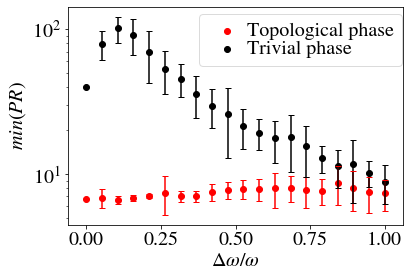

In [20]:
#np.savetxt("L40auxPRW_0.txt",  np.column_stack([np.abs(minPRvsW1-minPRvsW2),np.sqrt(sigmaPRW1**2+sigmaPRW2**2)]) )
#auxPRW, sigmaauxPRW= np.loadtxt("auxPRW_5.txt", unpack=True)
#aux2PRW, sigmaaux2PRW=np.loadtxt("L40auxPRW_0.txt", unpack=True)
#aux3PRW, sigmaaux3PRW=np.loadtxt("auxPRW_25.txt", unpack=True)
#aux4PRW, sigmaaux4PRW=np.loadtxt("L40auxPRW_05.txt", unpack=True)
#aux5PRW, sigmaaux5PRW=np.loadtxt("L40auxPRW_005.txt", unpack=True)
#aux6PRW, sigmaaux6PRW=np.loadtxt("auxPRW_m005.txt", unpack=True)
W_array=np.linspace(W_min, W_max, len(minPRvsW2))
plt.figure(figsize=[6,4])
#cmap1=mpl.cm.get_cmap('plasma_r')
#plt.scatter(W_array[States==0], np.abs(minPRvsW1-minPRvsW2)[States==0], s=70, c=precision[States==0], cmap=cmap1, label='Scattering Edge', marker='^')
#plt.scatter(W_array[States==1], np.abs(minPRvsW1-minPRvsW2)[States==1], s=70,  c=precision[States==1], cmap=cmap1, label='Edge Doublon', marker='s')
#plt.scatter(W_array[States==2], np.abs(minPRvsW1-minPRvsW2)[States==2], s=70, c=precision[States==2], cmap=cmap1, label='Bulk state', marker='o')
#plt.clim(0.5, 1)
#cb=plt.colorbar()
plt.scatter(W_array, minPRvsW1, color='red', label='Topological phase')
plt.scatter(W_array, minPRvsW2, color='black', label='Trivial phase')
plt.errorbar(W_array, minPRvsW1, sigmaPRW1, color='red', linestyle='None', capsize=3)
plt.errorbar(W_array, minPRvsW2, sigmaPRW2, color='black', linestyle='None', capsize=3)
#cb.set_label("Fraction of states in the class")
#plt.errorbar(W_array, np.abs(minPRvsW1-minPRvsW2), np.sqrt(sigmaPRW1**2+sigmaPRW2**2),zorder=0, capsize=3, color='black', linestyle='None')
#plt.scatter(W_array, aux5PRW, color='black', label='$U=0.05J_2$')
#plt.errorbar(W_array, aux5PRW, sigmaaux5PRW, capsize=5, color='black', linestyle='None')
#plt.scatter(W_array, auxPRW, color='blue', label='$U=5J_2$')
#plt.errorbar(W_array, auxPRW, sigmaauxPRW, capsize=5, color='blue', linestyle='None')
#plt.scatter(W_array, aux3PRW, color='green', label='$U=2.5J_2$')
#plt.errorbar(W_array, aux3PRW, sigmaaux3PRW, capsize=5, color='green', linestyle='None')
#plt.scatter(W_array, aux4PRW, color='blue', label='$U=0.5J_2$')
#plt.errorbar(W_array, aux4PRW, sigmaaux4PRW, capsize=5, color='blue', linestyle='None')
#plt.scatter(W_array, aux5PRW, color='magenta', label='$U=0.05J_2$')
#plt.errorbar(W_array, aux5PRW, sigmaaux5PRW, capsize=5, color='magenta', linestyle='None')
#plt.scatter(W_array, aux6PRW, color='brown', label='$U=0.05J_2$')
#plt.errorbar(W_array, aux6PRW, sigmaaux6PRW, capsize=5, color='brown', linestyle='None')
#plt.hlines(0, 0, W_max)
#plt.ylim(-2,7.5)
#plt.yscale('log')
plt.ylabel("$min(PR)$")
plt.xlabel("$\Delta \omega/\omega$")
plt.legend(loc=[0.39,0.73], framealpha=0.7, labelspacing=0, handletextpad=0)
plt.show()

In [12]:
"""W_min=0
W_max=1
n_points=40
W_array=np.linspace(W_min, W_max, n_points)
n_average=50
#Topological
MinPRvsUHyperMatrix11p = sweepWSubalg1p(W_min,W_max,n_points, N, n_average, -Jm, -JM)
minPRvsW11p=np.zeros(n_points)
auxPR11p=np.zeros(n_average)
sigmaPRW11p=np.zeros(n_points)
for i in range(n_points):
    for j in range(n_average):
        auxPR11p[j]=ComputeEigvalMinMaxTriv(MinPRvsUHyperMatrix11p[:,:,i, j])
    minPRvsW11p[i]= np.mean(auxPR11p)
    sigmaPRW11p[i]=np.std(auxPR11p)
#Trivial
MinPRvsUHyperMatrix21p = sweepWSubalg1p(W_min,W_max,n_points, N, n_average, -JM, -Jm)
minPRvsW21p=np.zeros(n_points)
auxPR21p=np.zeros(n_average)
sigmaPRW21p=np.zeros(n_points)
for i in range(n_points):
    for j in range(n_average):
        auxPR21p[j]=ComputeEigvalMinMaxTriv(MinPRvsUHyperMatrix21p[:,:,i, j])
    minPRvsW21p[i]= np.mean(auxPR21p)
    sigmaPRW21p[i]= np.std(auxPR21p)
"""

'W_min=0\nW_max=1\nn_points=40\nW_array=np.linspace(W_min, W_max, n_points)\nn_average=50\n#Topological\nMinPRvsUHyperMatrix11p = sweepWSubalg1p(W_min,W_max,n_points, N, n_average, -Jm, -JM)\nminPRvsW11p=np.zeros(n_points)\nauxPR11p=np.zeros(n_average)\nsigmaPRW11p=np.zeros(n_points)\nfor i in range(n_points):\n    for j in range(n_average):\n        auxPR11p[j]=ComputeEigvalMinMaxTriv(MinPRvsUHyperMatrix11p[:,:,i, j])\n    minPRvsW11p[i]= np.mean(auxPR11p)\n    sigmaPRW11p[i]=np.std(auxPR11p)\n#Trivial\nMinPRvsUHyperMatrix21p = sweepWSubalg1p(W_min,W_max,n_points, N, n_average, -JM, -Jm)\nminPRvsW21p=np.zeros(n_points)\nauxPR21p=np.zeros(n_average)\nsigmaPRW21p=np.zeros(n_points)\nfor i in range(n_points):\n    for j in range(n_average):\n        auxPR21p[j]=ComputeEigvalMinMaxTriv(MinPRvsUHyperMatrix21p[:,:,i, j])\n    minPRvsW21p[i]= np.mean(auxPR21p)\n    sigmaPRW21p[i]= np.std(auxPR21p)\n'

In [13]:
"""plt.figure(figsize=[8,6])
#plt.scatter(W_array, minPRvsW21p, color='black', label='Trivial Phase')
#plt.errorbar(W_array, minPRvsW21p, sigmaPRW21p, capsize=5, color='black', linestyle='None')
plt.scatter(W_array, np.abs(minPRvsW11p-minPRvsW21p), color='red', label='1 particle SSH')
plt.errorbar(W_array, np.abs(minPRvsW11p-minPRvsW21p), np.sqrt(sigmaPRW21p**2+sigmaPRW11p**2), capsize=5, color='red', linestyle='None')
plt.ylabel("$|min({PR}_{Topological})-min({PR}_{Trivial})|$")
plt.xlabel("$\Delta \omega/\omega$")
plt.hlines(0, 0, 1)
plt.legend()
plt.show()"""

'plt.figure(figsize=[8,6])\n#plt.scatter(W_array, minPRvsW21p, color=\'black\', label=\'Trivial Phase\')\n#plt.errorbar(W_array, minPRvsW21p, sigmaPRW21p, capsize=5, color=\'black\', linestyle=\'None\')\nplt.scatter(W_array, np.abs(minPRvsW11p-minPRvsW21p), color=\'red\', label=\'1 particle SSH\')\nplt.errorbar(W_array, np.abs(minPRvsW11p-minPRvsW21p), np.sqrt(sigmaPRW21p**2+sigmaPRW11p**2), capsize=5, color=\'red\', linestyle=\'None\')\nplt.ylabel("$|min({PR}_{Topological})-min({PR}_{Trivial})|$")\nplt.xlabel("$\\Delta \\omega/\\omega$")\nplt.hlines(0, 0, 1)\nplt.legend()\nplt.show()'

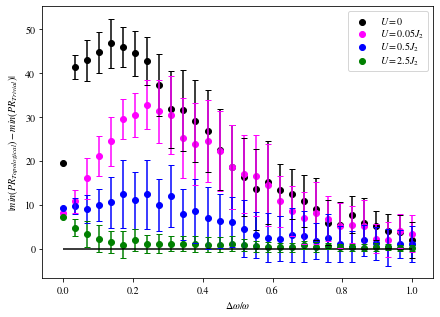

In [14]:
plt.figure(figsize=[7,5])
#auxPRW, sigmaauxPRW= np.loadtxt("auxPRW_5.txt", unpack=True)
aux2PRW, sigmaaux2PRW=np.loadtxt("LauxPRW_0.txt", unpack=True)
aux3PRW, sigmaaux3PRW=np.loadtxt("LauxPRW_25.txt", unpack=True)
aux4PRW, sigmaaux4PRW=np.loadtxt("LauxPRW_05.txt", unpack=True)
aux5PRW, sigmaaux5PRW=np.loadtxt("LauxPRW_005.txt", unpack=True)
#aux6PRW, sigmaaux6PRW=np.loadtxt("auxPRW_m005.txt", unpack=True)
W_array=np.linspace(W_min, W_max, len(aux2PRW))
plt.scatter(W_array, aux2PRW, color='black', label='$U=0$')
plt.errorbar(W_array, aux2PRW, sigmaaux5PRW, capsize=3, color='black', linestyle='None')
plt.scatter(W_array, aux5PRW, color='magenta', label='$U=0.05J_2$')
plt.errorbar(W_array, aux5PRW, sigmaaux5PRW, capsize=3, color='magenta', linestyle='None')
#plt.scatter(W_array, auxPRW, color='blue', label='$U=5J_2$')
#plt.errorbar(W_array, auxPRW, sigmaauxPRW, capsize=5, color='blue', linestyle='None')
plt.scatter(W_array, aux4PRW, color='blue', label='$U=0.5J_2$')
plt.errorbar(W_array, aux4PRW, sigmaaux4PRW, capsize=3, color='blue', linestyle='None')
plt.scatter(W_array, aux3PRW, color='green', label='$U=2.5J_2$')
plt.errorbar(W_array, aux3PRW, sigmaaux3PRW, capsize=3, color='green', linestyle='None')


#plt.scatter(W_array, aux6PRW, color='brown', label='$U=0.05J_2$')
#plt.errorbar(W_array, aux6PRW, sigmaaux6PRW, capsize=5, color='brown', linestyle='None')
plt.hlines(0, 0, W_max)
plt.ylabel("$|min({PR}_{Topological})-min({PR}_{Trivial})|$")
plt.xlabel("$\Delta \omega/\omega$")
plt.legend( labelspacing=0)
plt.show()